# ADL HW3 Part II

### Get the Data

In [1]:
import pathlib
import os
from PIL import Image
import numpy as np
import collections
import random
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
!cd ~
!curl -O http://download.tensorflow.org/example_images/flower_photos.tgz
!tar xzf flower_photos.tgz
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0  53.7M      0  0:00:04  0:00:04 --:--:-- 53.7M
flower_photos  flower_photos.tgz  sample_data


In [0]:
root_path = pathlib.Path('flower_photos')

In [4]:
os.listdir('flower_photos/')

['roses', 'dandelion', 'tulips', 'sunflowers', 'LICENSE.txt', 'daisy']

In [5]:
for item in root_path.iterdir():
    print(item)

flower_photos/roses
flower_photos/dandelion
flower_photos/tulips
flower_photos/sunflowers
flower_photos/LICENSE.txt
flower_photos/daisy


In [6]:
all_paths = list(root_path.glob('*/*'))
all_paths = [str(path) for path in all_paths]
random.shuffle(all_paths)

len(all_paths)

3670

### Read all JPG files

In [0]:
def load_and_resize_image(path):
    images = []
    for i in path:
        img = Image.open(i)
        resized_img = img.resize((200,200),Image.ANTIALIAS)
        if resized_img is not None: 
            images.append(np.array(resized_img)/255)
    return images

In [0]:
samples = load_and_resize_image(all_paths)

In [0]:
samples = np.asarray(samples)

In [10]:
# Investigate Image Shape
print(samples.shape)
print(samples.dtype)

(3670, 200, 200, 3)
float64


### Determine Label Names

In [11]:
label_names = sorted(item.name for item in root_path.glob('*/') if item.is_dir())
print(label_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [12]:
label = preprocessing.LabelEncoder()
label.fit(label_names)

LabelEncoder()

In [13]:
label.classes_

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

### Transform Labels to Numbers

In [0]:
all_label_names = [pathlib.Path(path).parent.name for path in all_paths]

In [0]:
all_image_labels = label.transform(all_label_names)

In [16]:
all_image_labels

array([4, 1, 0, ..., 1, 0, 1])

### Spliting Training and Testing Data

In [0]:
X_train, X_test, y_train, y_test = train_test_split(samples, all_image_labels, test_size=0.2)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2936, 200, 200, 3)
(734, 200, 200, 3)
(2936,)
(734,)


### Build Model with InceptionV3

In [0]:
model = models.Sequential()
model.add(InceptionV3(weights='imagenet', include_top=False, input_shape = (200,200,3)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation = 'softmax'))

In [48]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers.RMSprop(lr = 0.0001), metrics = ['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               4194432   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 645       
Total para

In [49]:
history = model.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split = 0.2)

Train on 2348 samples, validate on 588 samples
Epoch 1/5
2348/2348 [==============================] - 88s 37ms/step - loss: 1.4914 - acc: 0.3897 - val_loss: 0.6539 - val_acc: 0.7908
Epoch 2/5
2348/2348 [==============================] - 46s 19ms/step - loss: 0.8307 - acc: 0.6874 - val_loss: 0.4999 - val_acc: 0.8333
Epoch 3/5
2348/2348 [==============================] - 46s 19ms/step - loss: 0.5496 - acc: 0.8058 - val_loss: 0.5202 - val_acc: 0.8776
Epoch 4/5
2348/2348 [==============================] - 46s 19ms/step - loss: 0.3620 - acc: 0.8786 - val_loss: 0.6026 - val_acc: 0.8844
Epoch 5/5
2348/2348 [==============================] - 46s 19ms/step - loss: 0.2464 - acc: 0.9199 - val_loss: 0.6653 - val_acc: 0.9065


## **Evaluating on Test Set**

In [50]:
model.evaluate(X_test, y_test)

734/734 [==============================] - 4s 5ms/step


[0.6310683301261725, 0.8950953667105381]

## **Make 5 Predictions Based on the First 5 Test Samples**

In [0]:
predict_samples = X_test[:10]

In [0]:
predictions = model.predict_classes(predict_samples)

In [58]:
list(label.inverse_transform(predictions))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['daisy',
 'daisy',
 'sunflowers',
 'daisy',
 'daisy',
 'tulips',
 'tulips',
 'roses',
 'daisy',
 'dandelion']

## **Ground Truth Labels for the First 5 Samples**

In [59]:
list(label.inverse_transform(y_test[:10]))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['daisy',
 'daisy',
 'sunflowers',
 'daisy',
 'daisy',
 'tulips',
 'tulips',
 'roses',
 'daisy',
 'dandelion']

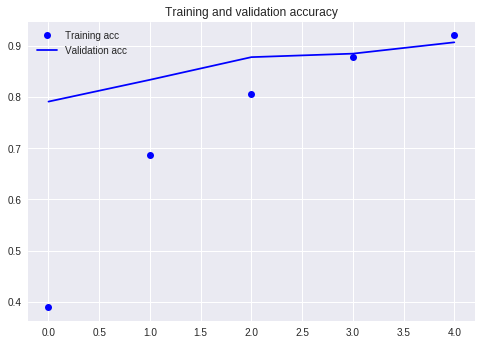

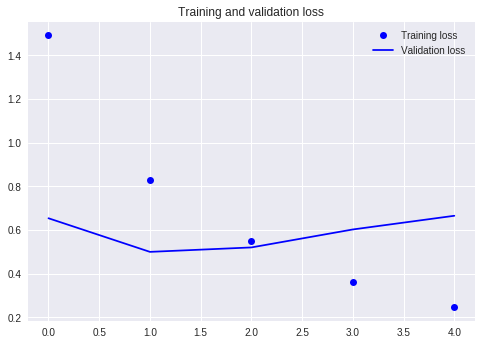

In [55]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


# **Evaluation**

### **As we can see, our model has reach a test score of 0.88 with loss score to be 0.62. **
### Predictions: our model has successfully made all 10 correct predictions. 